In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. Sampling from conditional distribution

Let $y \sim exp(\lambda)$. Simulate $X = Y | Y>a$ for any $a >0$.


First way: $Y| Y >a = a+ exp(\lambda)$

Second way: inverse CDF
$X$ has same distribution as $a - F^{-1}(p+(1-p)U)$ where $F$ is CDF of $Y$,$p = P(Y>a)$ and $U\sim Unif(0,1)$

In [5]:
# Inverse CDF
def inverse_cdf(a,t,lamd = 1):
    p = 1 - np.e**(-lamd *a) # F(a)
    return -np.log((1-p)*(1-t))/lamd  #F^{-1}(t) = -log(1-t)/lambda
    
def conditional_sample(n,a,lamd =1):
    u = np.random.uniform(size = n)
    return inverse_cdf(a,u,lamd)

(array([489., 267., 129.,  54.,  29.,  19.,   8.,   1.,   1.,   3.]),
 array([2.0005219 , 2.69521341, 3.38990492, 4.08459643, 4.77928794,
        5.47397945, 6.16867096, 6.86336248, 7.55805399, 8.2527455 ,
        8.94743701]),
 <BarContainer object of 10 artists>)

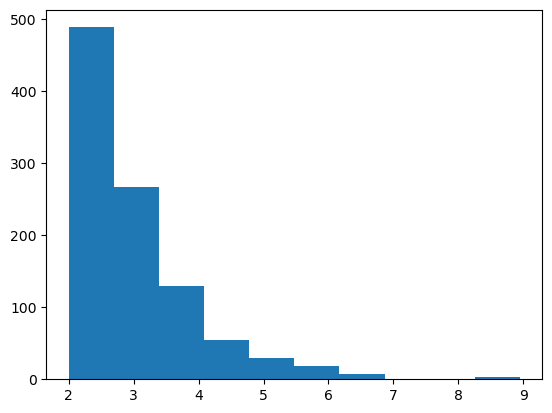

In [6]:
plt.hist(conditional_sample(1000,2,1))

Third way: Rejection Sampling

Generate $Y\sim exp(1)$, if $Y>a$ keep it other repeat.

Note: To get a sample of $Y>a$, you have to wait Geom$(e^{-\lambda a})$ time. For large, $\lambda$ or $a$ this is inefficient.

In [8]:
def rejection_sample(x,a,lamd =1):
    y = -float("inf")
    while y < a:
        y= np.random.exponential(scale = 1/lamd)
    return y

#function to apply on arrays
vectorized_rejection_sample = np.vectorize(rejection_sample)


#reject and keep only ones that are present
def rejection_sampling_exp(n,a,lamd = 1): #generate n exponential random variables and see how many of them are accepted
    x = np.random.exponential(scale = 1/lamd, size = n)
    return x[x>a]
    

144

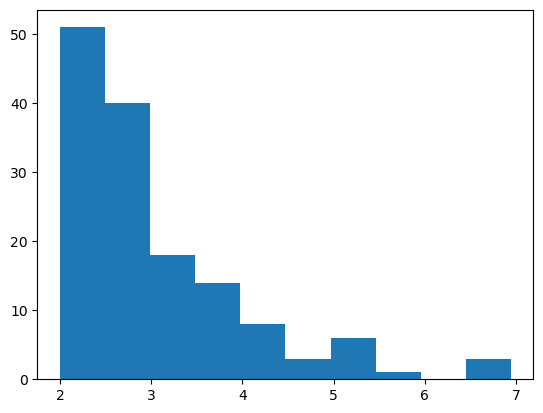

In [9]:
arr = rejection_sampling_exp(1000,2,1)
plt.hist(arr)## out of 1000 samples, we roughly expect
np.size(arr) # roughtly expect 1000*(e^{-2})~ 135 samples that are not rejected 

(array([479., 262., 113.,  70.,  38.,  17.,   8.,   5.,   3.,   5.]),
 array([2.00016792, 2.67465472, 3.34914151, 4.02362831, 4.69811511,
        5.3726019 , 6.0470887 , 6.72157549, 7.39606229, 8.07054909,
        8.74503588]),
 <BarContainer object of 10 artists>)

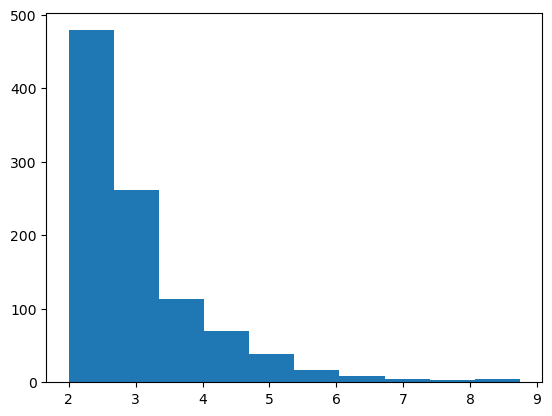

In [10]:
#same but now you can draw 1000 samples

plt.hist(vectorized_rejection_sample(np.zeros(1000),a=2,lamd=1))

## 2. Transformation

You want to sample from $\pi(x) \propto \tilde{\pi}(x)$. One way to do it is the following

1. $(U,V)$ is uniform on $G = \{(x,y): 0\leq x\leq \sqrt{\tilde{\pi}(\frac{x}{y})}\}$
2. $\frac{U}{V}$ is distributed as $\pi$


How do we sample uniformly from $G$ ? Say, if $G \subseteq [0,A]\times [-B,B] = \tilde{G}$, then you can uniformly sample from $\tilde{G}$. Now, now use rejection sample to sample from $G$.

For example, let $\tilde{\pi}(x) = e^{-x^2 /2}$. Then $\tilde{G} = [0,1]\times [-1,1]$.

In [14]:
def set_rejection_sample(x):
    U,V = np.random.uniform(0,1),np.random.uniform(-1,1)
    while U > np.exp(-U**2/(4* V**2)):
        U,V = np.random.uniform(0,1,1),np.random.uniform(-1,1,1)
    return U,V

def sample_pi(x):
    U,V = set_rejection_sample(x)
    return U/V
    
vectorized_sample_pi = np.vectorize(sample_pi)

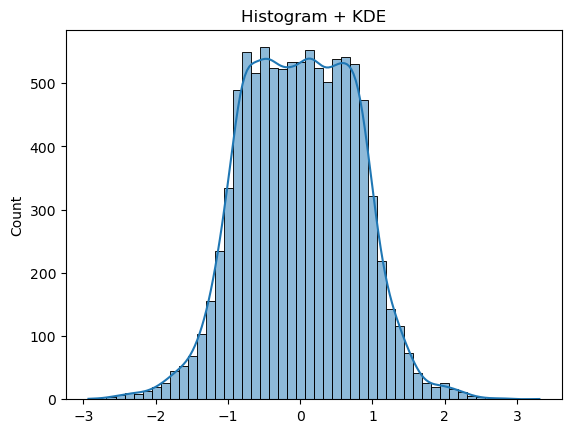

In [15]:
X = np.zeros(10000)
X = vectorized_sample_pi(X)


import seaborn as sns

sns.histplot(X, bins=50, kde=True)
plt.title("Histogram + KDE")
plt.show()

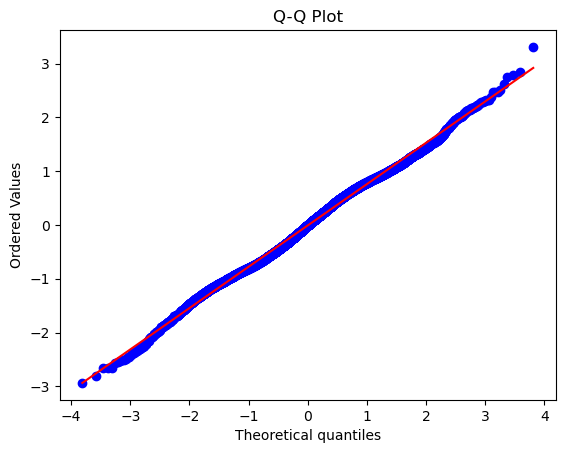

In [16]:
stats.probplot(X, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()


Q-Q plot shows that data is along the y=x line. So it normal as we would expect.

# 3. Rejection and Importance Sampling

You want to sample from $\pi$. You can sample from $q$. If support of $\pi$ is contained in support of $q$, and there exists $M >0$ such that $M > \sup(\frac{\pi(x)}{q(x)})$.

In fact, you only need to know $\pi(x) \propto \tilde{\pi}(x)$, and replace $\pi$ with $\tilde{\pi}$ in the above.

1. Sample $U\sim Unif(0,1)$.
2. Sample $X \sim q$.
3. Accept $X$ if $U \leq \frac{\tilde{\pi}(X)}{M q(X)}$ 


Example 1. $\tilde{\pi}(x) = x^{6} (1-x)^{7}$. This should be Beta(7,8) distribution.

In [40]:
M = 4 # larger M - takes longer to get samples, smaller M - bias and bad samples

def beta_pi(x, a=6, b=7):
    return x**(a-1) * (1-x)**(b-1) 
    
def beta_samples(M=4):
    U = np.random.uniform(0,1)
    X = np.random.uniform(0,1)
    while U >(beta_pi(X) / M):
        U = np.random.uniform(0,1)
        X = np.random.uniform(0,1)
    return X

vectorized_beta_samples = np.vectorize(beta_samples)

In [48]:
z = np.ones(1000)

z = vectorized_beta_samples(z)


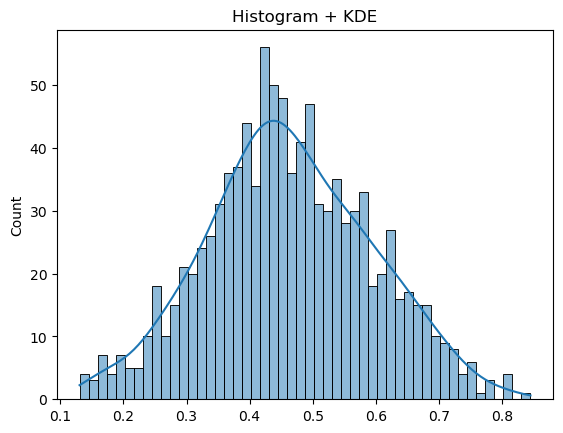

In [52]:
sns.histplot(z, bins=50, kde=True)
plt.title("Histogram")
plt.show()
